# Decision Tree
Decision Trees (DTs) are a non-parametric supervised learning method used for classification. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

## Instruction to Use
1. load data from Github. 
2. run `main`

## Input

1. .csv - produced by pre_processing.ipynb
2. The pre_processed input data includes following techniques:
   * MinMax Scaling
   * PCA
   * Correlation

## Output/Analysis

1. Visualising the accuracy of DT with k-fold validation.
2. Comparing the accuracy of DT model with and without PCA.   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import matplotlib.image as mpimg
import subprocess
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [2]:
acc = []
f1 =  []
acc1 = []
f11 =  []
df = pd.DataFrame()

In [3]:
def load_data(filename):
    return pd.read_csv(filename)

## Utility Function

In [4]:
def displayAnalysisGraphs(list1, acc,f1,model):
    plt.scatter(list1,acc)
    for i in range(len(list1)):
        acc[i]=float('{:,.3f}'.format(acc[i]))
        plt.annotate(str(acc[i]), xy=(list1[i], acc[i]))
    plt.ylabel("Accuracy")
    plt.title("Accuracy for dataset after different preprocessing techniques for "+model)
    plt.savefig("Accuracy"+model+".png")
    plt.show()
    plt.scatter(list1,f1)
    for i in range(len(list1)):
        f1[i]=float('{:,.3f}'.format(f1[i]))
        plt.annotate(str(f1[i]), xy=(list1[i], f1[i]))
    plt.ylabel("F1 score")
    plt.title("F1 scores for dataset after different preprocessing techniques for "+model)
    plt.savefig("F1_scores"+model+".png")
    plt.show()

# Spilt the input file into test and train dataset

I/P: dataframe

O/P: x_cross_val, y_cross_val, x_test, y_test

In [5]:
def prep_training(network_data):
    return train_test_split(network_data, train_size=0.8, test_size=0.2, random_state=42)

In [6]:
from pprint import pprint

In [7]:
def get_data(filename):
    return pd.read_csv(filename)

# Hyperparameter Tuning for Random Forest

The following hyperparamter tuning has taken reference from:
1. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
2. https://medium.com/@ODSC/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn-d60b7aa07ead

Instead of all the above the parameters, we will just focus on tuning a few as given below:
We will try adjusting a few of the following set of hyperparameters:
1. criterion = The function to measure the quality of a split. 
2. splitter = The strategy used to choose the split at each node.
3. max_depth = The maximum depth of the tree. 
4. min_samples_split = min number of data points placed in a node before the node is split
5. min_samples_leaf = min number of data points allowed in a leaf node
6. min_weight_fraction_leaf = The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. 
7. max_features = The number of features to consider when looking for the best split.

To use CV, we first need to create a parameter grid to sample from during fitting:

Params From reference github
- criterion=['gini', 'entropy']
- splitter = Not included
- max_depth = [2,4,6]
- min_samples_split = not included
- min_samples_leaf = not included
- min_weight_fraction_leaf = not included
- max_features = not included



### RandomizedSearch CV versus GridSearchCV

Grid Search is good when we work with a small number of hyperparameters. However, if the number of parameters to consider is particularly high and the magnitudes of influence are imbalanced, the better choice is to use the Random Search. [Reference](https://towardsdatascience.com/machine-learning-gridsearchcv-randomizedsearchcv-d36b89231b10)

Therefore, we have used GridSearchCV.

In [8]:
def creatingParamterGrid():
    max_depth = [2,4,6]    # Maximum number of levels in tree
    myCriterion = ['gini', 'entropy']
    
    # Create the parameter grid
    parameter_grid = {'max_depth': max_depth,
                     'criterion': myCriterion}
    return parameter_grid

## Cross-Validated Grid Search

We are now ready to create our grid-search object. We'll use each of the objects we've created thus far.
Instead of passing a `PredefinedSplit` object tothe `cv` paramter, we are simply passing the number of folds.

In [9]:
def prepToFindOptimalHyperParams(clf,parameter_grid):
    grid_search = GridSearchCV(estimator=clf, cv=3, param_grid = parameter_grid)
    return grid_search

## Training the Model

Now that we have created our `grid_search` object, we are ready to train our model.

In [10]:
def train(cross_val_df,grid_search):
    grid_search.fit(cross_val_df.drop("label",axis=1), cross_val_df["label"])
    Xpred = grid_search.predict(cross_val_df.drop("label",axis=1))
    print("accuracy on train is",accuracy_score(cross_val_df["label"],Xpred))

## Cross-validated Results

To examine the results individual fold, we use `grid_search`'s `cv_results_` attribute.
pd.DataFrame(grid_search.cv_results_).head()

## Optimal Hyperparamters

grid_search.best_params_
grid_search.best_score_
# Test the model and analyse it

In [11]:
def testDecisionTreeModel(test_df,grid_search,type):
    Ytest = test_df["label"]
    Ypred = grid_search.predict(test_df.drop("label",axis=1))
    print(classification_report(Ytest,Ypred))   
    acc1.append(accuracy_score(Ytest,Ypred))
    acc=accuracy_score(Ytest,Ypred)
    print('Accuracy of Decision Tree:',(acc)) 
    f1.append(f1_score(Ytest,Ypred))
    plt.savefig('confusion_matrix'+type+'.jpg')
    cm = confusion_matrix(Ytest, Ypred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax) 
    print(cm)
    return acc1

# Main Function

In [12]:
def main(network_data,type):  
    clf = DecisionTreeClassifier(random_state = 42)
    cross_val_df, test_df = prep_training(network_data)
    parameter_grid = creatingParamterGrid()
    pprint(parameter_grid)
    grid_search = prepToFindOptimalHyperParams(clf,parameter_grid)
    train(cross_val_df,grid_search)
    acc1=testDecisionTreeModel(test_df,grid_search,type)
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    return grid_search,acc1

## Classification with DT without Preprocessing
We also drop 'attack_cat' because there is only one encoded digit for non-attack category.

In [13]:
network_data = load_data('https://raw.githubusercontent.com/divyaKh/CMPE255Project/main/2.Data_Cleaning/cleaned_dataset_label_encoding.csv')

{'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6]}
accuracy on train is 0.9198304048744045
              precision    recall  f1-score   support

           0       0.91      0.86      0.89     18675
           1       0.92      0.95      0.94     32860

    accuracy                           0.92     51535
   macro avg       0.92      0.91      0.91     51535
weighted avg       0.92      0.92      0.92     51535

Accuracy of Decision Tree: 0.91974386339381
[[16041  2634]
 [ 1502 31358]]
{'criterion': 'gini', 'max_depth': 6}
0.9194956803083277


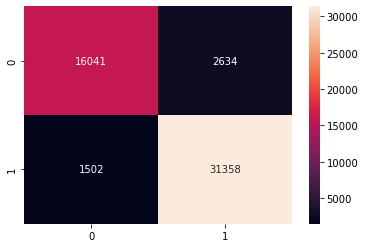

In [14]:
if 'attack_cat' in list(network_data):
    network_data = network_data.drop("attack_cat",axis=1)
grid_search,acc1 = main(network_data,'withoutpreprocess')

In [15]:
df['Accuracy_without_pp'] =acc1
df['F1_score_without_pp']=f1

In [16]:
df

,Accuracy_without_pp,F1_score_without_pp
0,0.919744,0.938132


## Classification with DT after MinMax Scaling 

In [17]:
network_data1 = load_data('../input/dataset_minmax.csv')

In [18]:
network_data1

,# dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1.833334e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000033,0.000000,0.090909,0.996078,...,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0,0
1,1.333334e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000121,0.000000,0.125000,0.996078,...,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0,0
2,8.333335e-08,0.901515,0.000000,0.5,0.000094,0.000000,0.000073,0.000000,0.200000,0.996078,...,0.000000,0.000000,0.031250,0.0,0.0,0.0,0.000000,0.032787,0.0,0
3,1.000000e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000061,0.000000,0.166667,0.996078,...,0.017241,0.000000,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0,0
4,1.666667e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000146,0.000000,0.100000,0.996078,...,0.017241,0.000000,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,1.500000e-07,0.901515,0.166667,0.5,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,...,0.396552,0.266667,0.359375,0.0,0.0,0.0,0.389831,0.377049,0.0,1
257669,8.429368e-03,0.856061,0.000000,0.4,0.000845,0.000726,0.000042,0.000024,0.000034,0.996078,...,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.000000,0.0,1
257670,1.500000e-07,0.901515,0.166667,0.5,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,...,0.034483,0.044444,0.187500,0.0,0.0,0.0,0.033898,0.180328,0.0,1
257671,1.500000e-07,0.901515,0.166667,0.5,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,...,0.500000,0.288889,0.453125,0.0,0.0,0.0,0.491525,0.475410,0.0,1


{'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6]}
accuracy on train is 0.9198304048744045
              precision    recall  f1-score   support

           0       0.91      0.86      0.89     18675
           1       0.92      0.95      0.94     32860

    accuracy                           0.92     51535
   macro avg       0.92      0.91      0.91     51535
weighted avg       0.92      0.92      0.92     51535

Accuracy of Decision Tree: 0.91974386339381
[[16041  2634]
 [ 1502 31358]]
{'criterion': 'gini', 'max_depth': 6}
0.9194956802377273


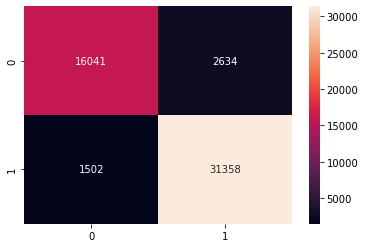

In [19]:
grid_search1,acc1= main(network_data1,'minmax')

In [20]:
pd.DataFrame(grid_search1.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.479458,0.050387,0.016084,0.000953,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.871233,0.871349,0.872220,0.871601,0.000441,5
1,0.877050,0.060274,0.016211,0.000154,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.908111,0.911181,0.909477,0.909590,0.001256,2
2,1.038018,0.018207,0.016353,0.000070,gini,6,"{'criterion': 'gini', 'max_depth': 6}",0.919840,0.918618,0.920029,0.919496,0.000625,1
3,0.492884,0.008837,0.015450,0.000296,entropy,2,"{'criterion': 'entropy', 'max_depth': 2}",0.870840,0.870985,0.872148,0.871324,0.000585,6
4,0.908223,0.063928,0.018266,0.003306,entropy,4,"{'criterion': 'entropy', 'max_depth': 4}",0.885247,0.887605,0.885944,0.886266,0.000989,4


In [21]:
df['Accuracy_rf_mm'] =acc1[1]
df['F1_score1_rf_mm']=f1[1]

In [22]:
df

,Accuracy_without_pp,F1_score_without_pp,Accuracy_rf_mm,F1_score1_rf_mm
0,0.919744,0.938132,0.919744,0.938132


# Classification with RF after MinMax Scaling + Correlation analysis

In [23]:
network_data2 = load_data('../input/dataset_minmax_corr.csv')

{'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6]}
accuracy on train is 0.9068197033055526
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     18675
           1       0.88      0.99      0.93     32860

    accuracy                           0.91     51535
   macro avg       0.93      0.88      0.89     51535
weighted avg       0.91      0.91      0.90     51535

Accuracy of Decision Tree: 0.9068982245076161
[[14199  4476]
 [  322 32538]]
{'criterion': 'gini', 'max_depth': 6}
0.9064752759828201


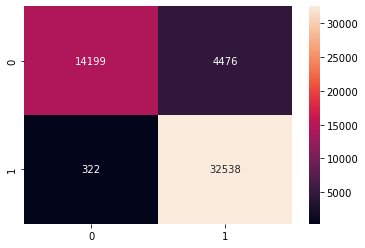

In [24]:
grid_search2,acc1 = main(network_data2,'minmax_corr')

In [25]:
pd.DataFrame(grid_search2.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.389580,0.020622,0.014246,0.000540,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.871233,0.871349,0.872220,0.871601,0.000441,5
1,0.644558,0.006311,0.014097,0.000160,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.895173,0.895769,0.895506,0.895483,0.000244,2
2,0.866244,0.007772,0.014628,0.000091,gini,6,"{'criterion': 'gini', 'max_depth': 6}",0.906582,0.905928,0.906916,0.906475,0.000411,1
3,0.420055,0.001415,0.013334,0.000203,entropy,2,"{'criterion': 'entropy', 'max_depth': 2}",0.870840,0.870985,0.872148,0.871324,0.000585,6
4,0.690103,0.004182,0.013803,0.000289,entropy,4,"{'criterion': 'entropy', 'max_depth': 4}",0.873401,0.873576,0.874039,0.873672,0.000269,4


In [26]:
df['Accuracy2_rf_mm_corr'] =acc1[2]
df['F1_score2_rf_mm_corr']=f1[2]

In [27]:
df

,Accuracy_without_pp,F1_score_without_pp,Accuracy_rf_mm,F1_score1_rf_mm,Accuracy2_rf_mm_corr,F1_score2_rf_mm_corr
0,0.919744,0.938132,0.919744,0.938132,0.906898,0.931334


## Classification with DT after Dimension Reduction (using PCA)

In [28]:
network_data3 = load_data('../input/dataset_pca.csv')

{'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6]}
accuracy on train is 0.8945948830395172
              precision    recall  f1-score   support

           0       0.99      0.72      0.83     18675
           1       0.86      1.00      0.92     32860

    accuracy                           0.90     51535
   macro avg       0.93      0.86      0.88     51535
weighted avg       0.91      0.90      0.89     51535

Accuracy of Decision Tree: 0.8954302900941108
[[13397  5278]
 [  111 32749]]
{'criterion': 'gini', 'max_depth': 6}
0.8938332552800577


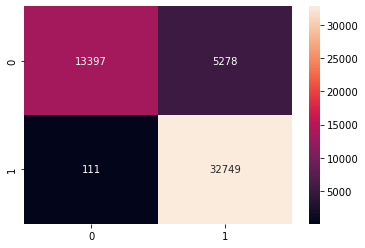

In [29]:
grid_search3,acc1 = main(network_data3,'pca')

In [30]:
pd.DataFrame(grid_search3.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.081177,0.078377,0.020639,0.006228,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.863214,0.864247,0.865817,0.864426,0.001070,5
1,1.788643,0.015720,0.015586,0.000177,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.881784,0.881245,0.881389,0.881473,0.000228,3
2,2.629381,0.012387,0.016195,0.000048,gini,6,"{'criterion': 'gini', 'max_depth': 6}",0.894241,0.893848,0.893410,0.893833,0.000339,1
3,1.249077,0.005637,0.014606,0.000099,entropy,2,"{'criterion': 'entropy', 'max_depth': 2}",0.843247,0.843028,0.840203,0.842159,0.001386,6
4,2.385280,0.063849,0.015990,0.000590,entropy,4,"{'criterion': 'entropy', 'max_depth': 4}",0.876181,0.876137,0.876499,0.876272,0.000161,4


In [31]:
df['Accuracy2_rf_pca'] =acc1[3]
df['F1_score2_rf_pca']=f1[3]

In [32]:
df

,Accuracy_without_pp,F1_score_without_pp,Accuracy_rf_mm,F1_score1_rf_mm,Accuracy2_rf_mm_corr,F1_score2_rf_mm_corr,Accuracy2_rf_pca,F1_score2_rf_pca
0,0.919744,0.938132,0.919744,0.938132,0.906898,0.931334,0.89543,0.923978


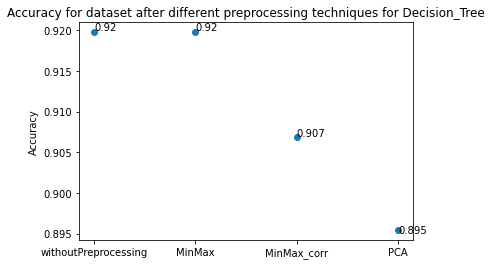

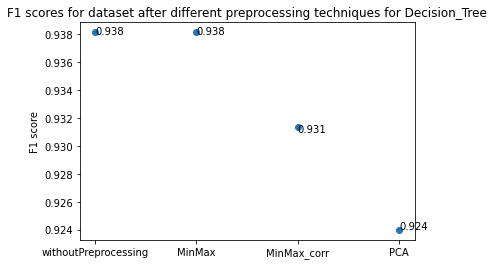

In [33]:
list1 = ['withoutPreprocessing','MinMax','MinMax_corr','PCA']
displayAnalysisGraphs(list1,acc1,f1,"Decision_Tree")

In [34]:
df.to_csv("Decision_Tree_result.csv")